# Calculation of CARs

## In this document:
The methodology used in this document follows a similar, but more advanced approach, to [this document explaining how to compute abnormal returns](https://nbviewer.jupyter.org/github/gouva12/Event-Study/blob/master/Event%20Study.ipynb)

###### 1. Referring to the Short Term Stock Price Reactions

    1.1) Raw Returns
    
    1.2) CAPM Adjusted Returns
    
    1.3) FF Adjusted Returns
    
    1.4) CAR Descriptive Stats
    
    1.5) Alternative Event Window CAR computation ( Paris Event only)


###### 2. CARS by Industry


###### 3. Long-term reaction: All CARS Computed for all days from Trump Election to End of 2018

    3.1) Using Rolling Estimation Window
    
    3.2) Using Fixed Estimation Window (original one for Trump's election)

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time
from dateutil.relativedelta import relativedelta

from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm

#for plots
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline


In [2]:
#import returns
returns = pd.read_excel("./CAR.xlsx", sheet_name = "Returns_")

#import Fama and French factors
FF = pd.read_excel("./CAR.xlsx", sheet_name = "FF_Factors")

C:\Users\jlbgo\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [3]:
returns.head()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY,TECHNIPFMC,AMCOR
2015-10-01,-0.009804,0.031629,0.005816,0.013426,0.013233,0.022222,-0.055687,-0.038271,-0.003662,-0.023438,...,0.016884,0.023637,0.023403,-0.004173,-0.022561,-0.019869,-0.043304,-0.007013,NaN,NaN
2015-10-02,0.019802,0.037302,0.008260,0.015211,0.012516,0.041063,0.016992,0.012218,0.013598,0.088000,...,0.090943,0.007623,0.009527,0.053154,0.045056,0.006328,0.007466,0.008744,NaN,NaN
2015-10-05,0.036791,0.031527,0.027307,0.000242,0.015407,-0.013921,0.017690,0.017054,0.022117,0.110294,...,-0.004497,0.018061,0.018643,0.012670,0.052730,-0.006754,0.038444,0.030172,NaN,NaN
2015-10-06,-0.012814,0.009074,0.012493,-0.036241,-0.028229,-0.054118,-0.027523,-0.088524,-0.005321,0.139073,...,-0.037179,0.001111,-0.000232,-0.017889,-0.024232,-0.006682,0.030330,0.001294,NaN,NaN
2015-10-07,0.029955,0.009465,0.017327,0.018551,0.009985,0.032338,0.013406,0.014933,0.010342,0.058140,...,-0.006135,0.003987,0.003474,-0.002948,0.017534,0.002478,0.023593,-0.000162,NaN,NaN


In [4]:
returns.tail()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY,TECHNIPFMC,AMCOR
2019-07-25,-0.035762,-0.008459,-0.038923,-0.006660,-0.011859,-0.121622,-0.017014,-0.013517,-0.003608,-0.022907,...,-0.011491,0.000000,-0.003662,-0.011364,-0.020721,-0.035355,-0.017372,0.006238,0.060250,0.017609
2019-07-26,0.021109,0.001659,0.025772,-0.002841,0.016502,-0.021538,0.012284,0.001653,0.014000,-0.033333,...,-0.008797,-0.002154,0.001470,0.003387,-0.004665,0.005797,-0.005616,0.018488,0.018942,-0.001821
2019-07-29,-0.020866,-0.004022,-0.007022,0.009117,-0.008560,-0.056604,0.040265,0.011993,-0.006189,-0.011149,...,-0.005071,-0.023390,-0.024220,-0.002016,-0.034064,0.018269,-0.006902,0.003844,-0.011575,-0.008212
2019-07-30,0.018350,0.006651,-0.007229,-0.002710,0.000000,-0.006667,-0.004242,0.011960,0.011976,0.000581,...,-0.030902,0.000737,-0.001880,-0.030013,0.008491,0.014967,-0.000842,-0.007021,-0.007807,-0.023919
2019-07-31,-0.015695,-0.012270,-0.001900,-0.013702,-0.008336,-0.130872,0.007987,-0.002399,-0.003787,0.011152,...,-0.016765,-0.018041,-0.018839,-0.019502,-0.008420,-0.022686,-0.023820,-0.010177,-0.015021,-0.000943


In [5]:
#Create Dataframe to put the final Cumulative Abnormal Returns
CAR_Table = pd.DataFrame(returns.columns)
CAR_Table.columns = ["Firm"]
CAR_Table.set_index("Firm", inplace = True, drop = False)
CAR_Table.head()

,Firm
Firm,
AAON,AAON
AAR,AAR
AARON'S,AARON'S
ABBOTT LABORATORIES,ABBOTT LABORATORIES
ABBVIE,ABBVIE


In [6]:
#Let's put the Fama and French values not in percentage
FF = FF/100

In [7]:
FF.head()

,Mkt-RF,SMB,HML,RF
2015-10-01,0.0013,-0.0045,-0.0004,0.0
2015-10-02,0.0148,0.0034,-0.0084,0.0
2015-10-05,0.0193,0.0062,0.0077,0.0
2015-10-06,-0.0043,-0.0023,0.0173,0.0
2015-10-07,0.0094,0.0070,-0.0024,0.0


In [8]:
#Let's remove firms that do not have stock returns for all the 126 trading days before 01-10-2015
#The date is 15-04-2016
#List of those firms:

firms_remove = [*returns.columns[returns.loc["2016-04-15"].isna()]]

In [9]:
#How many firms we will remove and how many we will have left
print(len(firms_remove), len(returns.columns) - len(firms_remove))

401 2616


In [10]:
#Let's drop these firms
returns.drop(columns = firms_remove, inplace = True)
CAR_Table.drop(index = firms_remove, inplace = True)

In [11]:
#Let's check if there is no further NAs in the dataset from 2015-04-15 onwards
returns.loc["2016-04-15":,:].isna().sum().sum()
#output is zero, so cool! There are no more missing values

0

In [12]:
#list of all firms
firms = list()
for firm in CAR_Table["Firm"]:
    firms.append(firm)
    
#Test if both lists are equal:
firms == [*returns.columns]

True

# SECTION 1

# 1.1) Raw Returns

In this section let's calculate the Raw Returns

In [13]:
FF.index.get_loc("2016-12-30")

315

In [14]:
#The index number for the days of the events:

#day one:
trumpd = FF.index.get_loc("2016-11-09")
scottd = FF.index.get_loc("2016-12-07")
parisd = FF.index.get_loc("2017-06-01")

#3 days:
trump3d = range(trumpd, trumpd +3)
scott3d = range(scottd, scottd +3)
paris3d = range(parisd, parisd +3)

#5 days:
trump5d = range(trumpd, trumpd +5)
scott5d = range(scottd, scottd +5)
paris5d = range(parisd, parisd +5)

#10 days:
trump10d = range(trumpd, trumpd +10)
scott10d = range(scottd, scottd +10)
paris10d = range(parisd, parisd +10)

#Until 30 Dec 2016: Trump and Scott only
trumpdec16 = range(trumpd, FF.index.get_loc("2016-12-30"))
scottdec16 = range(scottd, FF.index.get_loc("2016-12-30"))

#Until 29 Dec 2017:
trumpdec17 = range(trumpd, FF.index.get_loc("2017-12-29"))
scottdec17 = range(scottd, FF.index.get_loc("2017-12-29"))
parisdec17 = range(parisd, FF.index.get_loc("2017-12-29"))

#until dec 2018:
trumpdec18 = range(trumpd, FF.index.get_loc("2018-12-31"))
scottdec18 = range(scottd, FF.index.get_loc("2018-12-31"))
parisdec18 = range(parisd, FF.index.get_loc("2018-12-31"))

#experiment for Paris and Scott: Event Window with -x days and +x days
scott3dd = range(scottd -1, scottd +1)
scott5dd = range(scottd -2, scottd +2)
scott9dd = range(scottd -4, scottd +4)

paris3dd = range(parisd -1, parisd +1)
paris5dd = range(parisd -2, parisd +2)
paris9dd = range(parisd -4, parisd +4)


In [15]:
FF.index.get_loc("2017-12-29")

566

In [16]:
#Raw 1 day
#creating lists where we'll isert the raw returns
rawt= list()
raws= list()
rawp= list()

#For Trump (08-11-2016):
for firm in CAR_Table["Firm"]:
    rawt.append(returns[firm][trumpd])
CAR_Table["Trump_Raw_1d"] = rawt
    
#For Scott Pruitt (06-12-2016):
for firm in CAR_Table["Firm"]:
    raws.append(returns[firm][scottd])
CAR_Table["Scott_Raw_1d"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(returns[firm][parisd])
CAR_Table["Paris_Raw_1d"] = rawp


In [17]:
#Raw 3 days
#creating lists where we'll isert the raw returns
rawt= list()
raws= list()
rawp= list()

#For Trump (08-11-2016):
for firm in CAR_Table["Firm"]:
    rawt.append(sum(returns[firm].iloc[trump3d]))
CAR_Table["Trump_Raw_3d"] = rawt

#For Scott Pruitt (06-12-2016):
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scott3d]))
CAR_Table["Scott_Raw_3d"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(sum(returns[firm].iloc[paris3d]))
CAR_Table["Paris_Raw_3d"] = rawp


In [18]:
#Raw 5 days

#creating lists where we'll isert the raw returns
rawt= list()
raws= list()
rawp= list()

#For Trump (08-11-2016):
for firm in CAR_Table["Firm"]:
    rawt.append(sum(returns[firm].iloc[trump5d]))
CAR_Table["Trump_Raw_5d"] = rawt

#For Scott Pruitt (06-12-2016):
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scott5d]))
CAR_Table["Scott_Raw_5d"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(sum(returns[firm].iloc[paris5d]))
CAR_Table["Paris_Raw_5d"] = rawp


In [19]:
#Raw 10 days:

#creating lists where we'll isert the raw returns
rawt= list()
raws= list()
rawp= list()

#For Trump (08-11-2016):
for firm in CAR_Table["Firm"]:
    rawt.append(sum(returns[firm].iloc[trump10d]))
CAR_Table["Trump_Raw_10d"] = rawt

#For Scott Pruitt (06-12-2016):
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scott10d]))
CAR_Table["Scott_Raw_10d"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(sum(returns[firm].iloc[paris10d]))
CAR_Table["Paris_Raw_10d"] = rawp

In [20]:
#Raw until Dec 2016:

#creating lists where we'll isert the raw returns
rawt= list()
raws= list()

#For Trump (08-11-2016):
for firm in CAR_Table["Firm"]:
    rawt.append(sum(returns[firm].iloc[trumpdec16]))
CAR_Table["Trump_Raw_dec16"] = rawt

#For Scott Pruitt (06-12-2016):
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scottdec16]))
CAR_Table["Scott_Raw_dec16"] = raws

In [21]:
#Raw until Dec 2017:

#creating lists where we'll isert the raw returns
rawt= list()
raws= list()
rawp= list()

#For Trump (08-11-2016):
for firm in CAR_Table["Firm"]:
    rawt.append(sum(returns[firm].iloc[trumpdec17]))
CAR_Table["Trump_Raw_dec17"] = rawt

#For Scott Pruitt (06-12-2016):
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scottdec17]))
CAR_Table["Scott_Raw_dec17"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(sum(returns[firm].iloc[parisdec17]))
CAR_Table["Paris_Raw_dec17"] = rawp

In [22]:
CAR_Table.head()

,Firm,Trump_Raw_1d,Scott_Raw_1d,Paris_Raw_1d,Trump_Raw_3d,Scott_Raw_3d,Paris_Raw_3d,Trump_Raw_5d,Scott_Raw_5d,Paris_Raw_5d,Trump_Raw_10d,Scott_Raw_10d,Paris_Raw_10d,Trump_Raw_dec16,Scott_Raw_dec16,Trump_Raw_dec17,Scott_Raw_dec17,Paris_Raw_dec17
Firm,,,,,,,,,,,,,,,,,,
AAON,AAON,0.051146,-0.001527,0.015895,0.130524,0.009153,0.020137,0.134229,-0.001437,-0.001660,0.157299,0.023010,0.052835,0.173447,0.024848,0.297732,0.149134,0.031258
AAR,AAR,0.044712,0.002636,0.000286,0.079823,0.009745,0.013290,0.106889,-0.025269,-0.006879,0.178120,-0.008534,0.015291,0.041225,-0.118494,0.235738,0.076019,0.142477
AARON'S,AARON'S,0.022948,0.055188,0.043538,0.066974,0.072449,0.064697,0.087679,0.099670,0.083349,0.143589,0.117955,0.073079,0.226290,0.061121,0.527715,0.362547,0.145180
ABBOTT LABORATORIES,ABBOTT LABORATORIES,0.006026,0.001562,0.009636,0.007929,0.020203,0.020894,0.000072,0.026325,0.019631,-0.042774,-0.005495,0.042671,-0.036014,-0.002287,0.379281,0.413007,0.236107
ABBVIE,ABBVIE,0.065125,-0.026452,0.010451,0.072774,-0.000774,0.022412,0.069126,0.006545,0.040711,0.005133,0.009318,0.066295,0.070227,0.018616,0.530191,0.478580,0.405090


# 1.2) CAPM adjusted returns

Now Let's head to compute the betas for the CAPM

In [23]:
FF.head()

,Mkt-RF,SMB,HML,RF
2015-10-01,0.0013,-0.0045,-0.0004,0.0
2015-10-02,0.0148,0.0034,-0.0084,0.0
2015-10-05,0.0193,0.0062,0.0077,0.0
2015-10-06,-0.0043,-0.0023,0.0173,0.0
2015-10-07,0.0094,0.0070,-0.0024,0.0


In [24]:
#Let's first merge the FF factors and the stock returns from 01-10-2015 until 30-09-2016
est_window = FF.loc["2015-10-01":"2016-09-30"].join(returns.loc["2015-10-01":"2016-09-30"])

#For alternative Scott:
est_window_scott = FF.loc["2015-11-18":"2016-11-17"].join(returns.loc["2015-11-18":"2016-11-17"])

In [25]:
est_window

,Mkt-RF,SMB,HML,RF,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2015-10-01,0.0013,-0.0045,-0.0004,0.00000,-0.009804,0.031629,0.005816,0.013426,0.013233,0.022222,...,0.007815,-0.009180,0.016884,0.023637,0.023403,-0.004173,-0.022561,-0.019869,-0.043304,-0.007013
2015-10-02,0.0148,0.0034,-0.0084,0.00000,0.019802,0.037302,0.008260,0.015211,0.012516,0.041063,...,0.007129,0.066613,0.090943,0.007623,0.009527,0.053154,0.045056,0.006328,0.007466,0.008744
2015-10-05,0.0193,0.0062,0.0077,0.00000,0.036791,0.031527,0.027307,0.000242,0.015407,-0.013921,...,0.022851,0.034447,-0.004497,0.018061,0.018643,0.012670,0.052730,-0.006754,0.038444,0.030172
2015-10-06,-0.0043,-0.0023,0.0173,0.00000,-0.012814,0.009074,0.012493,-0.036241,-0.028229,-0.054118,...,-0.024162,-0.006081,-0.037179,0.001111,-0.000232,-0.017889,-0.024232,-0.006682,0.030330,0.001294
2015-10-07,0.0094,0.0070,-0.0024,0.00000,0.029955,0.009465,0.017327,0.018551,0.009985,0.032338,...,-0.004728,0.021704,-0.006135,0.003987,0.003474,-0.002948,0.017534,0.002478,0.023593,-0.000162
2015-10-08,0.0084,0.0024,0.0076,0.00000,0.034416,0.032349,0.033290,0.013045,0.007370,0.016867,...,-0.003750,-0.026661,-0.007988,-0.002428,-0.000692,-0.003696,0.019181,0.018248,0.021992,0.000485
2015-10-09,0.0012,0.0021,-0.0108,0.00000,-0.020619,0.008174,0.007243,0.017736,-0.007138,0.052133,...,-0.002635,-0.014648,0.039898,-0.001326,-0.000463,-0.003392,-0.011858,0.009596,0.014484,-0.001616
2015-10-12,0.0006,-0.0040,-0.0007,0.00000,0.009569,0.003604,0.003223,-0.007639,0.002336,-0.049550,...,0.008430,0.001041,0.010912,-0.018161,-0.015024,-0.015740,0.017962,0.019354,-0.000204,0.002427
2015-10-13,-0.0074,-0.0073,0.0069,0.00000,-0.021327,0.004039,-0.025457,-0.015636,-0.035324,-0.059242,...,-0.013974,0.017226,-0.063022,0.007445,0.002345,0.009076,0.006465,-0.022357,-0.008160,-0.006295
2015-10-14,-0.0060,-0.0026,-0.0003,0.00000,-0.015981,-0.007599,-0.035760,-0.004888,0.002602,0.002519,...,-0.006074,-0.000876,-0.051654,0.002238,-0.003746,-0.026877,-0.023124,0.051712,-0.016865,0.004873


In [26]:
len(est_window_scott)

253

In [27]:
#We will regress with excess returns, so let's compute them
for firm in CAR_Table["Firm"]:
    est_window[firm] = est_window[firm] - est_window["RF"]

#for Scott alternative
for firm in CAR_Table["Firm"]:
    est_window_scott[firm] = est_window_scott[firm] - est_window_scott["RF"]

In [28]:
len(est_window_scott)

253

In [29]:
#compute the betas for the CAPM, for each firm
#the regression is from 01-10-2015 until 30-09-2016
#firms daily excess returns vs market excess return
betas = list()
for firm in firms:
    betas.append(sm.OLS(endog=est_window[firm], exog= sm.add_constant(est_window["Mkt-RF"]), missing='drop').fit().params[1])
    
#Alternative for Scott:
betas_S = list()
for firm in firms:
    betas_S.append(sm.OLS(endog=est_window_scott[firm], exog= sm.add_constant(est_window_scott["Mkt-RF"]), missing='drop').fit().params[1])

C:\Users\jlbgo\Anaconda3\lib\site-packages\statsmodels\base\data.py:480: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if hasattr(x, 'ix'):


In [30]:
pd.DataFrame(betas).describe()

,0
count,2616.000000
mean,1.157495
std,1.309390
min,-1.317500
25%,0.816181
50%,1.103166
75%,1.404358
max,62.329819


In [31]:
#Resetting index of CAR_Table in order to insert the betas
CAR_Table.reset_index(inplace=True,drop=True)

#Insert the Betas
CAR_Table["CAPM_Beta"] = pd.DataFrame(betas)

#Insert alternative betas for scott
CAR_Table["CAPM_BetaS"] = pd.DataFrame(betas_S)

#Resetting Index once more, back to normal:
CAR_Table.set_index("Firm", drop= False, inplace= True)

In [32]:
CAR_Table["CAPM_Beta"].describe()

count    2616.000000
mean        1.157495
std         1.309390
min        -1.317500
25%         0.816181
50%         1.103166
75%         1.404358
max        62.329819
Name: CAPM_Beta, dtype: float64

Clearly from there are some betas that have very strange values.
That happens because some firms have their prices constant over various periods of days, leading to returns equalling zero
So, I will be removing the firms that have more than 20% of the dataset returns equaling zero.
Also, I will remove betas lower than -10% or higher than 300%

In [33]:
#firms to remove with more than 15% of their prices kept unchanged from one day to the next
firms_remove2 = list()
for firm in returns.columns:
    if len(returns[firm].loc[returns[firm] == 0])/len(returns) > 0.15:
        firms_remove2.append(firm)
len(firms_remove2)
    

51

In [34]:
#Let's drop these firms
returns.drop(columns = firms_remove2, inplace = True)
CAR_Table.drop(index = firms_remove2, inplace = True)

In [35]:
CAR_Table["CAPM_Beta"].describe()

count    2565.000000
mean        1.152651
std         0.514893
min        -0.451182
25%         0.832010
50%         1.113141
75%         1.412642
max         5.376398
Name: CAPM_Beta, dtype: float64

In [36]:
#firms to be removed with a beta lower than -10% ---> (minus 10%)
firms_remove3 = list()
for firm in returns.columns:
    if CAR_Table["CAPM_Beta"][firm] <= -0.1 or CAR_Table["CAPM_Beta"][firm] > 3:
        firms_remove3.append(firm)
         
len(firms_remove3)

15

In [37]:
#Let's drop these firms
returns.drop(columns = firms_remove3, inplace = True)
CAR_Table.drop(index = firms_remove3, inplace = True)

In [38]:
#Updating list of firms:
firms = [*returns.columns]
#checking for consistency between DataFrames
firms == [*CAR_Table["Firm"]]

True

In [39]:
#A cheat: I'll change the beta of CNX RESOURCES to 1.5
CAR_Table["CAPM_Beta"].loc["CNX RESOURCES"] = 1.5

C:\Users\jlbgo\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
CAR_Table["CAPM_Beta"].loc["CNX RESOURCES"]

1.5

In [41]:
est_window.head()

,Mkt-RF,SMB,HML,RF,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2015-10-01,0.0013,-0.0045,-0.0004,0.0,-0.009804,0.031629,0.005816,0.013426,0.013233,0.022222,...,0.007815,-0.009180,0.016884,0.023637,0.023403,-0.004173,-0.022561,-0.019869,-0.043304,-0.007013
2015-10-02,0.0148,0.0034,-0.0084,0.0,0.019802,0.037302,0.008260,0.015211,0.012516,0.041063,...,0.007129,0.066613,0.090943,0.007623,0.009527,0.053154,0.045056,0.006328,0.007466,0.008744
2015-10-05,0.0193,0.0062,0.0077,0.0,0.036791,0.031527,0.027307,0.000242,0.015407,-0.013921,...,0.022851,0.034447,-0.004497,0.018061,0.018643,0.012670,0.052730,-0.006754,0.038444,0.030172
2015-10-06,-0.0043,-0.0023,0.0173,0.0,-0.012814,0.009074,0.012493,-0.036241,-0.028229,-0.054118,...,-0.024162,-0.006081,-0.037179,0.001111,-0.000232,-0.017889,-0.024232,-0.006682,0.030330,0.001294
2015-10-07,0.0094,0.0070,-0.0024,0.0,0.029955,0.009465,0.017327,0.018551,0.009985,0.032338,...,-0.004728,0.021704,-0.006135,0.003987,0.003474,-0.002948,0.017534,0.002478,0.023593,-0.000162


Betas for Paris

In [42]:
#Let's first merge the FF factors and the stock returns from 01-10-2015 until 30-09-2016
est_windowp = FF.loc["2016-05-01":"2017-05-01"].join(returns.loc["2016-05-01":"2017-05-01"])

In [43]:
#We will regress with excess returns, so let's compute them
for firm in CAR_Table["Firm"]:
    est_windowp[firm] = est_windowp[firm] - est_windowp["RF"]

In [44]:
#compute the betas for the CAPM, for each firm
#the regression is from 01-10-2015 until 30-09-2016
#firms daily excess returns vs market excess return
betas = list()
for firm in firms:
    betas.append(sm.OLS(endog=est_windowp[firm], exog= sm.add_constant(est_windowp["Mkt-RF"]), missing='drop').fit().params[1])

In [45]:
#Resetting index of CAR_Table in order to insert the betas
CAR_Table.reset_index(inplace=True,drop=True)

#Insert the Betas
CAR_Table["CAPM_Betap"] = pd.DataFrame(betas)

#Resetting Index once more, back to normal:
CAR_Table.set_index("Firm", drop= False, inplace= True)

Now that we've calculated the betas and made further data cleaning, let's create the CAPM adjusted returns:

CAPM adjusted return = Raw Return - (rf + Beta*(Market excess return))

In [46]:
#CAPM adjusted returns : 1 day

#for Trump's election (08-11-2016):
CAR_Table["Trump_CAPM_ret_1d"] = CAR_Table["Trump_Raw_1d"] - \
(FF["RF"].iloc[trumpd] + CAR_Table["CAPM_Beta"]*FF["Mkt-RF"].iloc[trumpd])

#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_CAPM_ret_1d"] = CAR_Table["Scott_Raw_1d"] - \
(FF["RF"].iloc[scottd] + CAR_Table["CAPM_Beta"]*FF["Mkt-RF"].iloc[scottd])
 
#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_1d"] = CAR_Table["Paris_Raw_1d"] - \
(FF["RF"].iloc[parisd] + CAR_Table["CAPM_Betap"]*FF["Mkt-RF"].iloc[parisd])

In [47]:
#CAPM adjusted returns : 3 days

#for Trump's election (08-11-2016):
CAR_Table["Trump_CAPM_ret_3d"] = CAR_Table["Trump_Raw_3d"] - \
(sum(FF["RF"].iloc[trump3d]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[trump3d]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_CAPM_ret_3d"] = CAR_Table["Scott_Raw_3d"] - \
(sum(FF["RF"].iloc[scott3d]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scott3d]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_3d"] = CAR_Table["Paris_Raw_3d"] - \
(sum(FF["RF"].iloc[paris3d]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris3d]))

In [48]:
#CAPM adjusted returns : 5 days

#for Trump's election (08-11-2016):
CAR_Table["Trump_CAPM_ret_5d"] = CAR_Table["Trump_Raw_5d"] - \
(sum(FF["RF"].iloc[trump5d]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[trump5d]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_CAPM_ret_5d"] = CAR_Table["Scott_Raw_5d"] - \
(sum(FF["RF"].iloc[scott5d]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scott5d]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_5d"] = CAR_Table["Paris_Raw_5d"] - \
(sum(FF["RF"].iloc[paris5d]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris5d]))

In [49]:
#CAPM adjusted returns : 10 days

#for Trump's election (08-11-2016):
CAR_Table["Trump_CAPM_ret_10d"] = CAR_Table["Trump_Raw_10d"] - \
(sum(FF["RF"].iloc[trump10d]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[trump10d]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_CAPM_ret_10d"] = CAR_Table["Scott_Raw_10d"] - \
(sum(FF["RF"].iloc[scott10d]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scott10d]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_10d"] = CAR_Table["Paris_Raw_10d"] - \
(sum(FF["RF"].iloc[paris10d]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris10d]))

In [50]:
#CAPM adjusted returns : until dec 2016

#for Trump's election (08-11-2016):
CAR_Table["Trump_CAPM_ret_dec16"] = CAR_Table["Trump_Raw_dec16"] - \
(sum(FF["RF"].iloc[trumpdec16]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[trumpdec16]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_CAPM_ret_dec16"] = CAR_Table["Scott_Raw_dec16"] - \
(sum(FF["RF"].iloc[scottdec16]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scottdec16]))

In [51]:
#CAPM adjusted returns : until dec 2017

#for Trump's election (08-11-2016):
CAR_Table["Trump_CAPM_ret_dec17"] = CAR_Table["Trump_Raw_dec17"] - \
(sum(FF["RF"].iloc[trumpdec17]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[trumpdec17]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_CAPM_ret_dec17"] = CAR_Table["Scott_Raw_dec17"] - \
(sum(FF["RF"].iloc[scottdec17]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scottdec17]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_dec17"] = CAR_Table["Paris_Raw_dec17"] - \
(sum(FF["RF"].iloc[parisdec17]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[parisdec17]))

In [52]:
CAR_Table.loc[:,["Paris_CAPM_ret_1d","Paris_CAPM_ret_3d","Paris_CAPM_ret_5d","Paris_CAPM_ret_10d"]].describe()

,Paris_CAPM_ret_1d,Paris_CAPM_ret_3d,Paris_CAPM_ret_5d,Paris_CAPM_ret_10d
count,2550.000000,2550.000000,2550.000000,2550.000000
mean,0.005089,0.002706,0.001307,0.012992
std,0.020483,0.032608,0.042924,0.058558
min,-0.204527,-0.238726,-0.239641,-0.322211
25%,-0.003740,-0.011858,-0.017607,-0.016024
50%,0.003750,0.000703,0.000472,0.011759
75%,0.012348,0.014536,0.018284,0.042799
max,0.244252,0.302260,0.419616,0.375585


# 1.3) Fama and French 3 Factors adjusted returns

In this section I'll compute the betas for the 3 Fama and French factors, to then compute the FF 3 factors adjusted returns

In [53]:
#First remove from the estimation window the firms that we have excluded on firms_exclude2 and firms_exclude3
est_window.drop(columns = firms_remove2 + firms_remove3, inplace = True)

In [54]:
est_window.head()

,Mkt-RF,SMB,HML,RF,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2015-10-01,0.0013,-0.0045,-0.0004,0.0,-0.009804,0.031629,0.005816,0.013426,0.013233,0.022222,...,0.007815,-0.009180,0.016884,0.023637,0.023403,-0.004173,-0.022561,-0.019869,-0.043304,-0.007013
2015-10-02,0.0148,0.0034,-0.0084,0.0,0.019802,0.037302,0.008260,0.015211,0.012516,0.041063,...,0.007129,0.066613,0.090943,0.007623,0.009527,0.053154,0.045056,0.006328,0.007466,0.008744
2015-10-05,0.0193,0.0062,0.0077,0.0,0.036791,0.031527,0.027307,0.000242,0.015407,-0.013921,...,0.022851,0.034447,-0.004497,0.018061,0.018643,0.012670,0.052730,-0.006754,0.038444,0.030172
2015-10-06,-0.0043,-0.0023,0.0173,0.0,-0.012814,0.009074,0.012493,-0.036241,-0.028229,-0.054118,...,-0.024162,-0.006081,-0.037179,0.001111,-0.000232,-0.017889,-0.024232,-0.006682,0.030330,0.001294
2015-10-07,0.0094,0.0070,-0.0024,0.0,0.029955,0.009465,0.017327,0.018551,0.009985,0.032338,...,-0.004728,0.021704,-0.006135,0.003987,0.003474,-0.002948,0.017534,0.002478,0.023593,-0.000162


In [55]:
#Compute the betas
betas = {"Mkt-RF":[], "SMB": [], "HML":[],"Mkt-RF_S":[], "SMB_S": [], "HML_S":[]}
for firm in firms:
    reg = sm.OLS(endog=est_window[firm], exog= sm.add_constant(est_window.loc[:,["Mkt-RF", "SMB", "HML"]]), missing='drop').fit().params
    betas["Mkt-RF"].append(reg[1])
    betas["SMB"].append(reg[2])
    betas["HML"].append(reg[3])

#Alternative for Scott
for firm in firms:
    reg = sm.OLS(endog=est_window_scott[firm], exog= sm.add_constant(est_window_scott.loc[:,["Mkt-RF", "SMB", "HML"]]), missing='drop').fit().params
    betas["Mkt-RF_S"].append(reg[1])
    betas["SMB_S"].append(reg[2])
    betas["HML_S"].append(reg[3])



In [56]:
#Inserting betas
#Resetting index of CAR_Table in order to insert the betas
CAR_Table.reset_index(inplace=True,drop=True)

#Insert the Betas
CAR_Table["FF_Mkt-RF_Beta"] = pd.DataFrame(betas["Mkt-RF"])
CAR_Table["FF_HML_Beta"] = pd.DataFrame(betas["HML"])
CAR_Table["FF_SMB_Beta"] = pd.DataFrame(betas["SMB"])

CAR_Table["FF_Mkt-RF_BetaS"] = pd.DataFrame(betas["Mkt-RF_S"])
CAR_Table["FF_HML_BetaS"] = pd.DataFrame(betas["HML_S"])
CAR_Table["FF_SMB_BetaS"] = pd.DataFrame(betas["SMB_S"])

#Setting index again to Firms
CAR_Table.set_index("Firm", inplace = True, drop=False)


In [57]:
#Compute the betas for Paris
betas = {"Mkt-RF":[], "SMB": [], "HML":[]}
for firm in firms:
    reg = sm.OLS(endog=est_windowp[firm], exog= sm.add_constant(est_windowp.loc[:,["Mkt-RF", "SMB", "HML"]]), missing='drop').fit().params
    betas["Mkt-RF"].append(reg[1])
    betas["SMB"].append(reg[2])
    betas["HML"].append(reg[3])

In [58]:
#Inserting betas
#Resetting index of CAR_Table in order to insert the betas
CAR_Table.reset_index(inplace=True,drop=True)

#Insert the Betas
CAR_Table["FF_Mkt-RF_Betap"] = pd.DataFrame(betas["Mkt-RF"])
CAR_Table["FF_HML_Betap"] = pd.DataFrame(betas["HML"])
CAR_Table["FF_SMB_Betap"] = pd.DataFrame(betas["SMB"])

#Setting index again to Firms
CAR_Table.set_index("Firm", inplace = True, drop=False)

In [59]:
CAR_Table.iloc[:,-8:].describe()

,FF_HML_Beta,FF_SMB_Beta,FF_Mkt-RF_BetaS,FF_HML_BetaS,FF_SMB_BetaS,FF_Mkt-RF_Betap,FF_HML_Betap,FF_SMB_Betap
count,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000
mean,0.158082,0.750663,1.024844,0.164191,0.746221,1.008031,0.113044,0.702357
std,0.856178,0.821705,0.418569,0.806115,0.788683,0.437135,0.748940,0.689994
min,-3.118420,-1.643659,-0.144193,-3.102153,-1.429884,-0.421936,-3.820027,-1.707215
25%,-0.245690,0.183927,0.755681,-0.283380,0.209067,0.716523,-0.354350,0.203151
50%,0.119806,0.639670,0.996716,0.116445,0.650064,0.994814,0.066960,0.660110
75%,0.514970,1.163277,1.256716,0.531418,1.152591,1.263162,0.514001,1.089361
max,6.515332,6.538542,2.887654,6.300175,6.211238,2.818136,4.377922,6.678198


In [60]:
#FF 3 factors adjusted returns : 1 day

#for Trump's election (08-11-2016):
CAR_Table["Trump_FF_ret_1d"] = CAR_Table["Trump_Raw_1d"] - \
(FF["RF"].iloc[trumpd] + CAR_Table["FF_Mkt-RF_Beta"]*FF["Mkt-RF"].iloc[trumpd] + \
CAR_Table["FF_HML_Beta"]*FF["HML"].iloc[trumpd] + CAR_Table["FF_SMB_Beta"]*FF["SMB"].iloc[trumpd])

#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_FF_ret_1d"] = CAR_Table["Scott_Raw_1d"] - \
(FF["RF"].iloc[scottd] + CAR_Table["FF_Mkt-RF_Beta"]*FF["Mkt-RF"].iloc[scottd] + \
CAR_Table["FF_HML_Beta"]*FF["HML"].iloc[scottd] + CAR_Table["FF_SMB_Beta"]*FF["SMB"].iloc[scottd])
 
#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_1d"] = CAR_Table["Paris_Raw_1d"] - \
(FF["RF"].iloc[parisd] + CAR_Table["FF_Mkt-RF_Beta"]*FF["Mkt-RF"].iloc[parisd] + \
CAR_Table["FF_HML_Beta"]*FF["HML"].iloc[parisd] + CAR_Table["FF_SMB_Beta"]*FF["SMB"].iloc[parisd])

In [61]:
#FF 3 factors adjusted returns : 3 days

#for Trump's election (08-11-2016):
CAR_Table["Trump_FF_ret_3d"] = CAR_Table["Trump_Raw_3d"] - \
(sum(FF["RF"].iloc[trump3d]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[trump3d]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[trump3d]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[trump3d]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_FF_ret_3d"] = CAR_Table["Scott_Raw_3d"] - \
(sum(FF["RF"].iloc[scott3d]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scott3d]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scott3d]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scott3d]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_3d"] =CAR_Table["Paris_Raw_3d"] - \
(sum(FF["RF"].iloc[paris3d]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[paris3d]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[paris3d]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[paris3d]))

In [62]:
#FF 3 factors adjusted returns : 5 days

#for Trump's election (08-11-2016):
CAR_Table["Trump_FF_ret_5d"] = CAR_Table["Trump_Raw_5d"] - \
(sum(FF["RF"].iloc[trump5d]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[trump5d]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[trump5d]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[trump5d]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_FF_ret_5d"] = CAR_Table["Scott_Raw_5d"] - \
(sum(FF["RF"].iloc[scott5d]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scott5d]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scott5d]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scott5d]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_5d"] =CAR_Table["Paris_Raw_5d"] - \
(sum(FF["RF"].iloc[paris5d]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris5d]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris5d]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris5d]))

In [63]:
#FF 3 factors adjusted returns : 10 days

#for Trump's election (08-11-2016):
CAR_Table["Trump_FF_ret_10d"] = CAR_Table["Trump_Raw_10d"] - \
(sum(FF["RF"].iloc[trump10d]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[trump10d]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[trump10d]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[trump10d]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_FF_ret_10d"] = CAR_Table["Scott_Raw_10d"] - \
(sum(FF["RF"].iloc[scott10d]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scott10d]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scott10d]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scott10d]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_10d"] =CAR_Table["Paris_Raw_10d"] - \
(sum(FF["RF"].iloc[paris10d]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris10d]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris10d]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris10d]))

In [64]:
#FF 3 factors adjusted returns : until december 2016

#for Trump's election (08-11-2016):
CAR_Table["Trump_FF_ret_dec16"] = CAR_Table["Trump_Raw_dec16"] - \
(sum(FF["RF"].iloc[trumpdec16]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[trumpdec16]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[trumpdec16]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[trumpdec16]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_FF_ret_dec16"] = CAR_Table["Scott_Raw_dec16"] - \
(sum(FF["RF"].iloc[scottdec16]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scottdec16]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scottdec16]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scottdec16]))


In [65]:
parisdec17

range(419, 566)

In [66]:
#FF 3 factors adjusted returns : until december 2017

#for Trump's election (08-11-2016):
CAR_Table["Trump_FF_ret_dec17"] = CAR_Table["Trump_Raw_dec17"] - \
(sum(FF["RF"].iloc[trumpdec17]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[trumpdec17]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[trumpdec17]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[trumpdec17]))


#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_FF_ret_dec17"] = CAR_Table["Scott_Raw_dec17"] - \
(sum(FF["RF"].iloc[scottdec17]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scottdec17]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scottdec17]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scottdec17]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_dec17"] =CAR_Table["Paris_Raw_dec17"] - \
(sum(FF["RF"].iloc[parisdec17]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[parisdec17]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[parisdec17]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[parisdec17]))

In [67]:
FF

,Mkt-RF,SMB,HML,RF
2015-10-01,0.0013,-0.0045,-0.0004,0.00000
2015-10-02,0.0148,0.0034,-0.0084,0.00000
2015-10-05,0.0193,0.0062,0.0077,0.00000
2015-10-06,-0.0043,-0.0023,0.0173,0.00000
2015-10-07,0.0094,0.0070,-0.0024,0.00000
2015-10-08,0.0084,0.0024,0.0076,0.00000
2015-10-09,0.0012,0.0021,-0.0108,0.00000
2015-10-12,0.0006,-0.0040,-0.0007,0.00000
2015-10-13,-0.0074,-0.0073,0.0069,0.00000
2015-10-14,-0.0060,-0.0026,-0.0003,0.00000


In [68]:
#Ordering the columns for presentation purposes
CAR_Table = CAR_Table.reindex_axis(['Firm', 'CAPM_Beta','CAPM_BetaS','CAPM_Betap', 'FF_HML_Beta', 'FF_Mkt-RF_Beta', 'FF_SMB_Beta','FF_HML_Betap', 'FF_Mkt-RF_Betap', 'FF_SMB_Betap','FF_Mkt-RF_BetaS','FF_HML_BetaS', 'FF_SMB_BetaS' ,'Trump_Raw_1d', 'Trump_Raw_3d', 'Trump_Raw_5d', 'Trump_Raw_10d', 'Trump_Raw_dec16', 'Trump_Raw_dec17', 'Trump_CAPM_ret_1d', 'Trump_CAPM_ret_3d', 'Trump_CAPM_ret_5d', 'Trump_CAPM_ret_10d', 'Trump_CAPM_ret_dec16', 'Trump_CAPM_ret_dec17', 'Trump_FF_ret_1d', 'Trump_FF_ret_3d', 'Trump_FF_ret_5d', 'Trump_FF_ret_10d', 'Trump_FF_ret_dec16', 'Trump_FF_ret_dec17', 'Scott_Raw_1d', 'Scott_Raw_3d', 'Scott_Raw_5d', 'Scott_Raw_10d', 'Scott_Raw_dec16', 'Scott_Raw_dec17', 'Scott_CAPM_ret_1d', 'Scott_CAPM_ret_3d', 'Scott_CAPM_ret_5d', 'Scott_CAPM_ret_10d', 'Scott_CAPM_ret_dec16', 'Scott_CAPM_ret_dec17', 'Scott_FF_ret_1d', 'Scott_FF_ret_3d', 'Scott_FF_ret_5d', 'Scott_FF_ret_10d', 'Scott_FF_ret_dec16', 'Scott_FF_ret_dec17', 'Paris_Raw_1d', 'Paris_Raw_3d', 'Paris_Raw_5d', 'Paris_Raw_10d', 'Paris_Raw_dec17', 'Paris_CAPM_ret_1d', 'Paris_CAPM_ret_3d', 'Paris_CAPM_ret_5d', 'Paris_CAPM_ret_10d', 'Paris_CAPM_ret_dec17', 'Paris_FF_ret_1d', 'Paris_FF_ret_3d', 'Paris_FF_ret_5d', 'Paris_FF_ret_10d', 'Paris_FF_ret_dec17', 'Scott_CAPM_ret_3dd', 'Scott_CAPM_ret_5dd', 'Scott_CAPM_ret_9dd', 'Scott_FF_ret_3dd', 'Scott_FF_ret_5dd', 'Scott_FF_ret_10dd', 'Paris_CAPM_ret_3dd', 'Paris_CAPM_ret_5dd', 'Paris_CAPM_ret_9dd', 'Paris_FF_ret_3dd', 'Paris_FF_ret_5dd', 'Paris_FF_ret_9dd', 'Scott_CAPM_ret_1ddd', 'Scott_CAPM_ret_3ddd', 'Scott_CAPM_ret_5ddd', 'Scott_CAPM_ret_10ddd','Scott_FF_ret_1ddd', 'Scott_FF_ret_3ddd', 'Scott_FF_ret_5ddd', 'Scott_FF_ret_10ddd','Paris_CAPM_ret_1ddd', 'Paris_CAPM_ret_3ddd', 'Paris_CAPM_ret_5ddd', 'Paris_CAPM_ret_10ddd','Paris_FF_ret_1ddd', 'Paris_FF_ret_3ddd', 'Paris_FF_ret_5ddd', 'Paris_FF_ret_10ddd'], axis = 1)

C:\Users\jlbgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


In [69]:
CAR_Table.head()

,Firm,CAPM_Beta,CAPM_BetaS,CAPM_Betap,FF_HML_Beta,FF_Mkt-RF_Beta,FF_SMB_Beta,FF_HML_Betap,FF_Mkt-RF_Betap,FF_SMB_Betap,...,Scott_FF_ret_5ddd,Scott_FF_ret_10ddd,Paris_CAPM_ret_1ddd,Paris_CAPM_ret_3ddd,Paris_CAPM_ret_5ddd,Paris_CAPM_ret_10ddd,Paris_FF_ret_1ddd,Paris_FF_ret_3ddd,Paris_FF_ret_5ddd,Paris_FF_ret_10ddd
Firm,,,,,,,,,,,,,,,,,,,,,
AAON,AAON,1.259150,1.203801,1.369699,-0.080094,1.104519,1.054117,0.079081,0.928751,1.223789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAR,AAR,1.318933,1.257314,1.552335,0.627641,1.046554,1.503216,0.399091,1.066778,1.185130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AARON'S,AARON'S,1.404146,1.400963,1.413330,0.414938,1.228273,0.966163,-0.010330,1.139914,0.789741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABBOTT LABORATORIES,ABBOTT LABORATORIES,1.103702,1.103362,1.048730,-0.521912,1.153835,-0.089757,-0.523829,1.192255,-0.138974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABBVIE,ABBVIE,0.889188,0.991580,0.901053,-1.037275,0.880714,0.532842,-0.643775,0.944865,0.209534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
#Raw Returns until 2018
#For Trump (08-11-2016):
rawt= list()
for firm in CAR_Table.index:
    rawt.append(sum(returns[firm].iloc[trumpdec18]))
CAR_Table["Trump_Raw_dec18"] = rawt

#CAPM returns until 2018
#for Trump's election (08-11-2016):
CAR_Table["Trump_CAPM_ret_dec18"] = CAR_Table["Trump_Raw_dec18"] - \
(sum(FF["RF"].iloc[trumpdec18]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[trumpdec18]))


#FF 3 factors until 2018
#for Trump's election (08-11-2016):
CAR_Table["Trump_FF_ret_dec18"] = CAR_Table["Trump_Raw_dec18"] - \
(sum(FF["RF"].iloc[trumpdec18]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[trumpdec18]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[trumpdec18]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[trumpdec18]))

# 1.4) The CAR Table Descriptive Statistics

In [71]:
CAR_Table.columns

Index(['Firm', 'CAPM_Beta', 'CAPM_BetaS', 'CAPM_Betap', 'FF_HML_Beta',
       'FF_Mkt-RF_Beta', 'FF_SMB_Beta', 'FF_HML_Betap', 'FF_Mkt-RF_Betap',
       'FF_SMB_Betap', 'FF_Mkt-RF_BetaS', 'FF_HML_BetaS', 'FF_SMB_BetaS',
       'Trump_Raw_1d', 'Trump_Raw_3d', 'Trump_Raw_5d', 'Trump_Raw_10d',
       'Trump_Raw_dec16', 'Trump_Raw_dec17', 'Trump_CAPM_ret_1d',
       'Trump_CAPM_ret_3d', 'Trump_CAPM_ret_5d', 'Trump_CAPM_ret_10d',
       'Trump_CAPM_ret_dec16', 'Trump_CAPM_ret_dec17', 'Trump_FF_ret_1d',
       'Trump_FF_ret_3d', 'Trump_FF_ret_5d', 'Trump_FF_ret_10d',
       'Trump_FF_ret_dec16', 'Trump_FF_ret_dec17', 'Scott_Raw_1d',
       'Scott_Raw_3d', 'Scott_Raw_5d', 'Scott_Raw_10d', 'Scott_Raw_dec16',
       'Scott_Raw_dec17', 'Scott_CAPM_ret_1d', 'Scott_CAPM_ret_3d',
       'Scott_CAPM_ret_5d', 'Scott_CAPM_ret_10d', 'Scott_CAPM_ret_dec16',
       'Scott_CAPM_ret_dec17', 'Scott_FF_ret_1d', 'Scott_FF_ret_3d',
       'Scott_FF_ret_5d', 'Scott_FF_ret_10d', 'Scott_FF_ret_dec16',
       'Sco

In [72]:
CAR_Table.iloc[:,1:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAPM_Beta,2550.0,1.145477,0.487266,-0.090589,0.832343,1.112275,1.406458,2.964006
CAPM_BetaS,2550.0,1.154012,0.496622,-0.140958,0.829799,1.119652,1.419402,3.063993
CAPM_Betap,2550.0,1.273380,0.551338,-0.401486,0.904220,1.253363,1.615706,3.522066
FF_HML_Beta,2550.0,0.158082,0.856178,-3.118420,-0.245690,0.119806,0.514970,6.515332
FF_Mkt-RF_Beta,2550.0,1.020725,0.407149,-0.122525,0.768642,0.989401,1.248260,2.708512
FF_SMB_Beta,2550.0,0.750663,0.821705,-1.643659,0.183927,0.639670,1.163277,6.538542
FF_HML_Betap,2550.0,0.113044,0.748940,-3.820027,-0.354350,0.066960,0.514001,4.377922
FF_Mkt-RF_Betap,2550.0,1.008031,0.437135,-0.421936,0.716523,0.994814,1.263162,2.818136
FF_SMB_Betap,2550.0,0.702357,0.689994,-1.707215,0.203151,0.660110,1.089361,6.678198
FF_Mkt-RF_BetaS,2550.0,1.024844,0.418569,-0.144193,0.755681,0.996716,1.256716,2.887654


In [73]:
CAR_Table.iloc[:,1:].describe().transpose().to_excel("./CAR_Stats.xlsx")

#  1.5) The CAR Table using different periods for Paris and Scott only

1.5.1) I'll test Scott and Paris using an event window that represents -x days and +x days

In [74]:
#Raw 3 days
raws = list()
rawp = list()

#For Scott (07-12-2017)
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scott3dd]))
CAR_Table["Scott_Raw_3dd"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(sum(returns[firm].iloc[paris3dd]))
CAR_Table["Paris_Raw_3dd"] = rawp

In [75]:
#Raw 5 days
raws = list()
rawp = list()

#For Scott (07-12-2017)
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scott5dd]))
CAR_Table["Scott_Raw_5dd"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(sum(returns[firm].iloc[paris5dd]))
CAR_Table["Paris_Raw_5dd"] = rawp

In [76]:
#Raw 9 days
rawp = list()
raws = list()

#For Scott (07-12-2017)
for firm in CAR_Table["Firm"]:
    raws.append(sum(returns[firm].iloc[scott9dd]))
CAR_Table["Scott_Raw_9dd"] = raws

#For Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
for firm in CAR_Table["Firm"]:
    rawp.append(sum(returns[firm].iloc[paris9dd]))
CAR_Table["Paris_Raw_9dd"] = rawp

In [77]:
#CAPM 3 days

#For Scott (07-12-2017)
CAR_Table["Scott_CAPM_ret_3dd"] = CAR_Table["Scott_Raw_3dd"] - \
(sum(FF["RF"].iloc[scott3dd]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scott3dd]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_3dd"] = CAR_Table["Paris_Raw_3dd"] - \
(sum(FF["RF"].iloc[paris3dd]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris3dd]))

In [78]:
#CAPM 5 days

#For Scott (07-12-2017)
CAR_Table["Scott_CAPM_ret_5dd"] = CAR_Table["Scott_Raw_5dd"] - \
(sum(FF["RF"].iloc[scott5dd]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scott5dd]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_5dd"] = CAR_Table["Paris_Raw_5dd"] - \
(sum(FF["RF"].iloc[paris5dd]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris5dd]))

In [79]:
#CAPM 9 days

#For Scott (07-12-2017)
CAR_Table["Scott_CAPM_ret_9dd"] = CAR_Table["Scott_Raw_5dd"] - \
(sum(FF["RF"].iloc[scott9dd]) + CAR_Table["CAPM_Beta"]*sum(FF["Mkt-RF"].iloc[scott9dd]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_CAPM_ret_9dd"] = CAR_Table["Paris_Raw_9dd"] - \
(sum(FF["RF"].iloc[paris9dd]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris9dd]))

In [80]:
#FF 3 days

#For Scott (07-12-2017)
CAR_Table["Scott_FF_ret_3dd"] =CAR_Table["Scott_Raw_3dd"] - \
(sum(FF["RF"].iloc[scott3dd]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scott3dd]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scott3dd]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scott3dd]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_3dd"] =CAR_Table["Paris_Raw_3dd"] - \
(sum(FF["RF"].iloc[paris3dd]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris3dd]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris3dd]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris3dd]))

In [81]:
#FF 5 days

#For Scott (07-12-2017)
CAR_Table["Scott_FF_ret_5dd"] =CAR_Table["Scott_Raw_5dd"] - \
(sum(FF["RF"].iloc[scott5dd]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scott5dd]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scott5dd]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scott5dd]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_5dd"] =CAR_Table["Paris_Raw_5dd"] - \
(sum(FF["RF"].iloc[paris5dd]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris5dd]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris5dd]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris5dd]))

In [82]:
#FF 9 days

#For Scott (07-12-2017)
CAR_Table["Scott_FF_ret_9dd"] =CAR_Table["Scott_Raw_9dd"] - \
(sum(FF["RF"].iloc[scott9dd]) + CAR_Table["FF_Mkt-RF_Beta"]*sum(FF["Mkt-RF"].iloc[scott9dd]) + \
CAR_Table["FF_HML_Beta"]*sum(FF["HML"].iloc[scott9dd]) + CAR_Table["FF_SMB_Beta"]*sum(FF["SMB"].iloc[scott9dd]))

#for Paris Agreement Withdrawal (01-06-2017) MARKETS STILL OPEN ON DAY
CAR_Table["Paris_FF_ret_9dd"] =CAR_Table["Paris_Raw_9dd"] - \
(sum(FF["RF"].iloc[paris9dd]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris9dd]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris9dd]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris9dd]))

1.5.2) Alternative Estimation Window for Scott (Paris has been calculated already)

In [83]:
#Alternative estimation window for Scott

#CAPM adjusted returns : 1 day, 3 days, 5 days, 10 days

#for Scott Pruitt (06-12-2016):
CAR_Table["Scott_CAPM_ret_1ddd"] = CAR_Table["Scott_Raw_1d"] - \
(FF["RF"].iloc[scottd] + CAR_Table["CAPM_BetaS"]*FF["Mkt-RF"].iloc[scottd])

CAR_Table["Scott_CAPM_ret_3ddd"] = CAR_Table["Scott_Raw_3d"] - \
(sum(FF["RF"].iloc[scott3d]) + CAR_Table["CAPM_BetaS"]*sum(FF["Mkt-RF"].iloc[scott3d]))

CAR_Table["Scott_CAPM_ret_5ddd"] = CAR_Table["Scott_Raw_5d"] - \
(sum(FF["RF"].iloc[scott5d]) + CAR_Table["CAPM_BetaS"]*sum(FF["Mkt-RF"].iloc[scott5d]))

CAR_Table["Scott_CAPM_ret_10ddd"] = CAR_Table["Scott_Raw_10d"] - \
(sum(FF["RF"].iloc[scott10d]) + CAR_Table["CAPM_BetaS"]*sum(FF["Mkt-RF"].iloc[scott10d]))


#FF adjusted returns

CAR_Table["Scott_FF_ret_1ddd"] = CAR_Table["Scott_Raw_1d"] - \
(FF["RF"].iloc[scottd] + CAR_Table["FF_Mkt-RF_BetaS"]*FF["Mkt-RF"].iloc[scottd] + \
CAR_Table["FF_HML_BetaS"]*FF["HML"].iloc[scottd] + CAR_Table["FF_SMB_BetaS"]*FF["SMB"].iloc[scottd])

CAR_Table["Scott_FF_ret_3ddd"] = CAR_Table["Scott_Raw_3d"] - \
(sum(FF["RF"].iloc[scott3d]) + CAR_Table["FF_Mkt-RF_BetaS"]*sum(FF["Mkt-RF"].iloc[scott3d]) + \
CAR_Table["FF_HML_BetaS"]*sum(FF["HML"].iloc[scott3d]) + CAR_Table["FF_SMB_BetaS"]*sum(FF["SMB"].iloc[scott3d]))

CAR_Table["Scott_FF_ret_5ddd"] = CAR_Table["Scott_Raw_5d"] - \
(sum(FF["RF"].iloc[scott5d]) + CAR_Table["FF_Mkt-RF_BetaS"]*sum(FF["Mkt-RF"].iloc[scott5d]) + \
CAR_Table["FF_HML_BetaS"]*sum(FF["HML"].iloc[scott5d]) + CAR_Table["FF_SMB_BetaS"]*sum(FF["SMB"].iloc[scott5d]))

CAR_Table["Scott_FF_ret_10ddd"] = CAR_Table["Scott_Raw_10d"] - \
(sum(FF["RF"].iloc[scott10d]) + CAR_Table["FF_Mkt-RF_BetaS"]*sum(FF["Mkt-RF"].iloc[scott10d]) + \
CAR_Table["FF_HML_BetaS"]*sum(FF["HML"].iloc[scott10d]) + CAR_Table["FF_SMB_BetaS"]*sum(FF["SMB"].iloc[scott10d]))

#Alternative Estimation window for Paris

CAR_Table["Paris_CAPM_ret_1ddd"] = CAR_Table["Paris_Raw_1d"] - \
(FF["RF"].iloc[parisd] + CAR_Table["CAPM_Betap"]*FF["Mkt-RF"].iloc[parisd])

CAR_Table["Paris_CAPM_ret_3ddd"] = CAR_Table["Paris_Raw_3d"] - \
(sum(FF["RF"].iloc[paris3d]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris3d]))

CAR_Table["Paris_CAPM_ret_5ddd"] = CAR_Table["Paris_Raw_5d"] - \
(sum(FF["RF"].iloc[paris5d]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris5d]))

CAR_Table["Paris_CAPM_ret_10ddd"] = CAR_Table["Paris_Raw_10d"] - \
(sum(FF["RF"].iloc[paris10d]) + CAR_Table["CAPM_Betap"]*sum(FF["Mkt-RF"].iloc[paris10d]))


#FF adjusted returns

CAR_Table["Paris_FF_ret_1ddd"] = CAR_Table["Paris_Raw_1d"] - \
(FF["RF"].iloc[parisd] + CAR_Table["FF_Mkt-RF_Betap"]*FF["Mkt-RF"].iloc[parisd] + \
CAR_Table["FF_HML_Betap"]*FF["HML"].iloc[parisd] + CAR_Table["FF_SMB_Betap"]*FF["SMB"].iloc[parisd])

CAR_Table["Paris_FF_ret_3ddd"] = CAR_Table["Paris_Raw_3d"] - \
(sum(FF["RF"].iloc[paris3d]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris3d]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris3d]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris3d]))

CAR_Table["Paris_FF_ret_5ddd"] = CAR_Table["Paris_Raw_5d"] - \
(sum(FF["RF"].iloc[paris5d]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris5d]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris5d]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris5d]))

CAR_Table["Paris_FF_ret_10ddd"] = CAR_Table["Paris_Raw_10d"] - \
(sum(FF["RF"].iloc[paris10d]) + CAR_Table["FF_Mkt-RF_Betap"]*sum(FF["Mkt-RF"].iloc[paris10d]) + \
CAR_Table["FF_HML_Betap"]*sum(FF["HML"].iloc[paris10d]) + CAR_Table["FF_SMB_Betap"]*sum(FF["SMB"].iloc[paris10d]))



In [85]:
CAR_Table.to_excel("./CAR_Table.xlsx")

# SECTION 2

# CARs by Industry

In [86]:
#Let's bring a new file with the firms that also have the Industry code:
sic_codes = pd.read_excel("./extractions.xlsx", sheet_name = "All_Companies", usecols = "J:P", skiprows = 1)

In [87]:
sic_codes.set_index("NAME", inplace = True, drop = False)

In [88]:
sic_codes.head()

,Code,Tick,TICK_DUPLICATE,SIC,FF_30Ind,FF_12Ind,NAME
NAME,,,,,,,
AAON,544294,AAON,1,3580,13 - Fabricated Products and Machinery,03 - Manufacturing,AAON
AAR,923587,AIR,1,3724,"16 - Aircraft, ships, and railroad equipment",03 - Manufacturing,AAR
AARON'S,938972,AAN,1,7359,22 - Personal and Business Services,12 - Other,AARON'S
ABBOTT LABORATORIES,916328,ABT,1,5047,26 - Wholesale,09 - Shops,ABBOTT LABORATORIES
ABBVIE,87851X,ABBV,1,2834,"08 - Healthcare, Medical Equipment, Pharmaceut...",10 - Healthcare,ABBVIE


In [89]:
CAR_Table = pd.merge(CAR_Table,sic_codes.loc[:,["NAME","FF_30Ind","FF_12Ind"]], left_on = "Firm", right_on = "NAME")
CAR_Table.drop(columns = "NAME", inplace = True)

C:\Users\jlbgo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: 'NAME' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\jlbgo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: 'Firm' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
#Checking if merge was successful in terms of number of firms
len(CAR_Table) == len(firms)

True

In [91]:
#Saving CAR Table
CAR_Table.to_excel("./CAR_Table.xlsx")

In [92]:
ind_table = pd.pivot_table(CAR_Table, ["Trump_CAPM_ret_1d","Trump_CAPM_ret_dec16"],["FF_30Ind"], aggfunc = np.mean)

In [93]:
ind_table

,Trump_CAPM_ret_1d,Trump_CAPM_ret_dec16
FF_30Ind,,
01 - Food Products,-0.009341,0.039789
02 - Beer & Liquor,-0.007670,0.005578
03 - Tobacco Products,-0.012819,0.023168
04 - Recreation,0.004235,0.028602
05 - Printing and Publishing,0.013723,0.055995
06 - Consumer Goods,-0.001131,-0.006843
07 - Apparel,-0.003425,-0.070259
"08 - Healthcare, Medical Equipment, Pharmaceutical Products",0.034843,-0.010104
09 - Chemicals,0.008946,0.052008


C:\Users\jlbgo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):


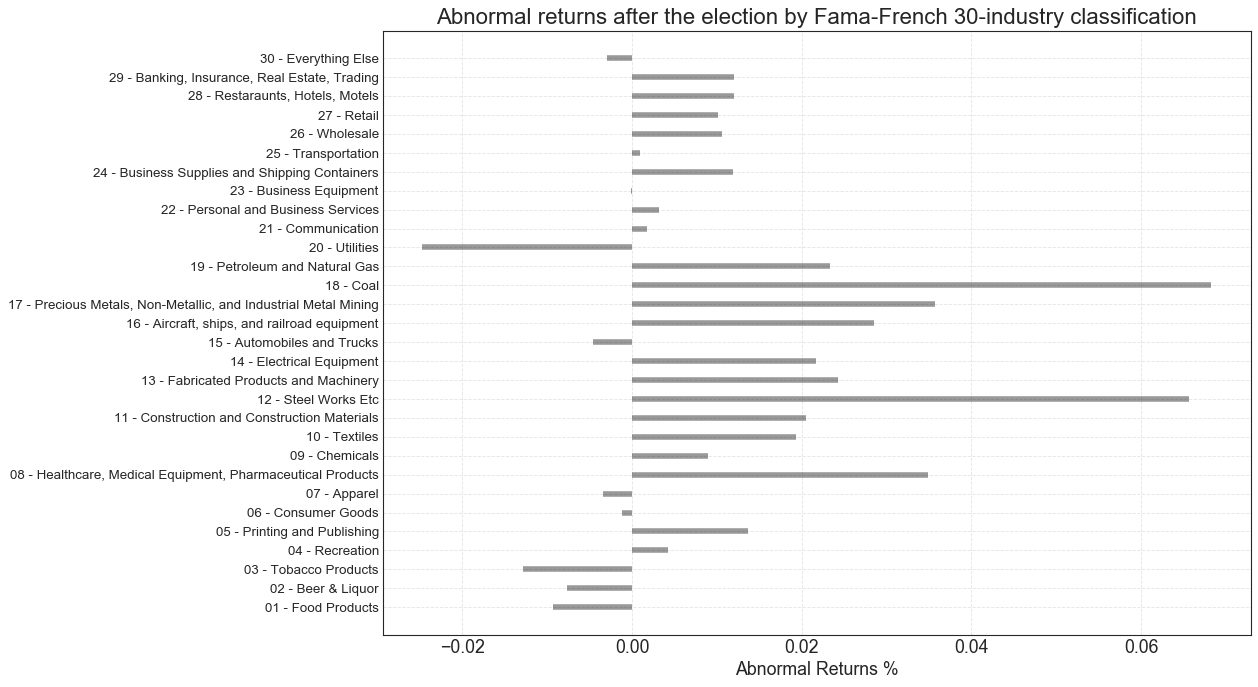

In [94]:
x = ind_table
#ind_table['mpg_z'] = (x - x.mean())/x.std()
#ind_table['colors'] = ['red' if x < 0 else 'green' for x in ind_table['mpg_z']]

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=ind_table.index, xmin=0, xmax=ind_table.Trump_CAPM_ret_1d,  alpha=0.4, linewidth=5)


# Decorations
plt.gca().set( xlabel='Abnormal Returns %')
plt.yticks(ind_table.index, fontsize=12)
plt.title('Abnormal returns after the election by Fama-French 30-industry classification', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# SECTION 3

In [95]:
#We will run regressions vs excess returns:
excessreturns = pd.DataFrame(index = returns.index, columns = returns.columns) #creating DataFrame

for firm in firms:
    excessreturns[firm] = returns[firm] - FF["RF"]
excessreturns.head()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2015-10-01,-0.009804,0.031629,0.005816,0.013426,0.013233,0.022222,-0.055687,-0.038271,-0.003662,-0.023438,...,0.007815,-0.009180,0.016884,0.023637,0.023403,-0.004173,-0.022561,-0.019869,-0.043304,-0.007013
2015-10-02,0.019802,0.037302,0.008260,0.015211,0.012516,0.041063,0.016992,0.012218,0.013598,0.088000,...,0.007129,0.066613,0.090943,0.007623,0.009527,0.053154,0.045056,0.006328,0.007466,0.008744
2015-10-05,0.036791,0.031527,0.027307,0.000242,0.015407,-0.013921,0.017690,0.017054,0.022117,0.110294,...,0.022851,0.034447,-0.004497,0.018061,0.018643,0.012670,0.052730,-0.006754,0.038444,0.030172
2015-10-06,-0.012814,0.009074,0.012493,-0.036241,-0.028229,-0.054118,-0.027523,-0.088524,-0.005321,0.139073,...,-0.024162,-0.006081,-0.037179,0.001111,-0.000232,-0.017889,-0.024232,-0.006682,0.030330,0.001294
2015-10-07,0.029955,0.009465,0.017327,0.018551,0.009985,0.032338,0.013406,0.014933,0.010342,0.058140,...,-0.004728,0.021704,-0.006135,0.003987,0.003474,-0.002948,0.017534,0.002478,0.023593,-0.000162


In [96]:
excessreturns.tail()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2019-07-25,-0.035852,-0.008549,-0.039013,-0.006750,-0.011949,-0.121712,-0.017104,-0.013607,-0.003698,-0.022997,...,0.003707,0.001151,-0.011581,-0.000090,-0.003752,-0.011454,-0.020811,-0.035445,-0.017462,0.006148
2019-07-26,0.021019,0.001569,0.025682,-0.002931,0.016412,-0.021628,0.012194,0.001563,0.013910,-0.033423,...,-0.010558,-0.028357,-0.008887,-0.002244,0.001380,0.003297,-0.004755,0.005707,-0.005706,0.018398
2019-07-29,-0.020956,-0.004112,-0.007112,0.009027,-0.008650,-0.056694,0.040175,0.011903,-0.006279,-0.011239,...,-0.005513,0.003482,-0.005161,-0.023480,-0.024310,-0.002106,-0.034154,0.018179,-0.006992,0.003754
2019-07-30,0.018260,0.006561,-0.007319,-0.002800,-0.000090,-0.006757,-0.004332,0.011870,0.011886,0.000491,...,-0.004112,-0.003141,-0.030992,0.000647,-0.001970,-0.030103,0.008401,0.014877,-0.000932,-0.007111
2019-07-31,-0.015785,-0.012360,-0.001990,-0.013792,-0.008426,-0.130962,0.007897,-0.002489,-0.003877,0.011062,...,0.004577,-0.005956,-0.016855,-0.018131,-0.018929,-0.019592,-0.008510,-0.022776,-0.023910,-0.010267


## 3.1 With Rolling Window

Below I wrote a code to compute all the betas. It takes hours to run, so I ran it once and saved the output on the excel file "betas"

To get these values again, I just import the information from that same excel file.

Below is the code originally written, but all in coments, so that I won't need to run it again

In [97]:
#Creating Dataframe for the betas, from Election Day until end of 2018
#allbetas = pd.DataFrame(index = returns.loc['2016-11-09':].index, columns = returns.columns)

In [98]:
# Computing the betas (1 year estimation window, from -(1y & 1M) until -(1M))

#for firm in firms:
    
#    betas = list()
#    for date in allbetas.index:

        #estimation window of 1Y:
#        day = excessreturns.index.get_loc(date)
#        window = range(day - 252, day - 22)

#        betas.append(sm.OLS(endog=excessreturns.iloc[window].loc[:,firm], exog= sm.add_constant(FF.iloc[window].loc[:, "Mkt-RF"]), missing='drop').fit().params[1])

    #inserting in betas DataFrame
#    allbetas.loc[:,firm] = pd.DataFrame(betas, index = allbetas.index)[0]

In [99]:
#saving the betas because this thing takes hours to run
#allbetas.to_excel("./betas.xlsx")

In [100]:
#Extracting the betas again:

allbetas = pd.read_excel("./betas.xlsx")

In [101]:
allbetas.tail()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2019-07-25,1.144363,1.156928,0.941426,0.996175,0.798654,1.939519,0.908876,1.621783,1.014826,2.061100,...,0.825758,1.265175,1.705805,1.014179,1.022290,1.774552,1.215013,1.628941,1.394999,1.000859
2019-07-26,1.143596,1.157527,0.942356,0.995063,0.796905,1.948370,0.914132,1.623864,1.016726,2.062342,...,0.825067,1.262676,1.706670,1.017515,1.025480,1.778976,1.214157,1.632467,1.392645,0.998787
2019-07-29,1.151219,1.146020,0.956594,0.992672,0.854690,1.937031,0.934065,1.608698,1.009530,2.057487,...,0.806163,1.272473,1.694719,1.033236,1.040870,1.772330,1.215716,1.648492,1.395643,1.000150
2019-07-30,1.151707,1.147359,0.966935,0.993737,0.854671,1.940127,0.933273,1.600543,1.010823,2.058707,...,0.806221,1.270089,1.692787,1.032921,1.040291,1.772394,1.214845,1.643381,1.396915,1.000322
2019-07-31,1.158963,1.155598,0.929656,0.994515,0.851370,1.968503,0.921893,1.593464,1.016063,2.043550,...,0.801068,1.269971,1.692582,1.038873,1.047141,1.765290,1.217438,1.658347,1.379790,1.000700


In [102]:
#creating DataFrame for CAPM Returns
CAPM = pd.DataFrame(index = allbetas.index, columns= allbetas.columns)

for firm in firms:
    CAPM[firm] = allbetas[firm]*FF.loc["2016-11-09": ,"Mkt-RF"] + FF.loc["2016-11-09": ,"RF"]

CAPM.head()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2016-11-09,0.017030,0.018607,0.019738,0.016051,0.013402,0.025371,0.017882,0.018779,0.010340,0.032004,...,0.011518,0.020409,0.018690,0.025182,0.023751,0.021485,0.014504,0.023973,0.025735,0.017333
2016-11-10,0.003744,0.004081,0.004342,0.003529,0.002949,0.005567,0.003923,0.004133,0.002269,0.007063,...,0.002523,0.004493,0.004110,0.005528,0.005211,0.004705,0.003209,0.005255,0.005650,0.003802
2016-11-11,0.002116,0.002289,0.002552,0.002031,0.001658,0.003140,0.002191,0.002340,0.001291,0.003938,...,0.001425,0.002550,0.002318,0.003112,0.002923,0.002662,0.001838,0.002953,0.003243,0.002149
2016-11-14,0.002454,0.002654,0.002979,0.002364,0.001937,0.003642,0.002560,0.002746,0.001516,0.004615,...,0.001684,0.003012,0.002781,0.003649,0.003431,0.003144,0.002196,0.003443,0.003735,0.002506
2016-11-15,0.009283,0.010189,0.011300,0.008998,0.007362,0.013680,0.009557,0.010517,0.005724,0.017924,...,0.006348,0.011402,0.010334,0.013934,0.013099,0.012060,0.008218,0.013076,0.014141,0.009578


In [103]:
CAPM.tail()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2019-07-25,-0.007119,-0.007199,-0.005841,-0.006186,-0.004942,-0.012129,-0.005636,-0.010127,-0.006303,-0.012895,...,-0.005112,-0.007881,-0.010657,-0.006299,-0.006350,-0.011090,-0.007565,-0.010172,-0.008698,-0.006215
2019-07-26,0.009467,0.009582,0.007817,0.008250,0.006625,0.016067,0.007586,0.013406,0.008427,0.017001,...,0.006856,0.010444,0.014085,0.008434,0.008499,0.014678,0.010046,0.013476,0.011510,0.008280
2019-07-29,-0.003594,-0.003577,-0.002971,-0.003087,-0.002645,-0.006108,-0.002899,-0.005058,-0.003140,-0.006494,...,-0.002490,-0.003982,-0.005333,-0.003216,-0.003241,-0.005581,-0.003800,-0.005185,-0.004376,-0.003110
2019-07-30,-0.001868,-0.001861,-0.001554,-0.001599,-0.001363,-0.003208,-0.001497,-0.002631,-0.001628,-0.003410,...,-0.001281,-0.002069,-0.002788,-0.001666,-0.001678,-0.002923,-0.001975,-0.002704,-0.002285,-0.001611
2019-07-31,-0.012543,-0.012506,-0.010043,-0.010750,-0.009190,-0.021367,-0.009959,-0.017279,-0.010985,-0.022185,...,-0.008642,-0.013753,-0.018359,-0.011234,-0.011324,-0.019152,-0.013180,-0.017986,-0.014950,-0.010818


In [104]:
CAR = returns.loc["2016-11-09":] - CAPM

In [105]:
CAR.to_excel("./CAR_longrun.xlsx")

In [106]:
#stats for the CARs
stats = CAR.describe().transpose().describe()

In [107]:
stats

,count,mean,std,min,25%,50%,75%,max
count,2550.0,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000
mean,684.0,-0.000111,0.020875,-0.135645,-0.010161,-0.000365,0.009545,0.156050
std,0.0,0.000928,0.011971,0.100929,0.004966,0.001020,0.004162,0.189319
min,684.0,-0.005336,0.006490,-1.011818,-0.037396,-0.007224,0.003479,0.024760
25%,684.0,-0.000561,0.013124,-0.170072,-0.012004,-0.000815,0.006650,0.070907
50%,684.0,-0.000124,0.017436,-0.104458,-0.008694,-0.000232,0.008322,0.113482
75%,684.0,0.000344,0.024678,-0.067716,-0.006780,0.000245,0.011211,0.179734
max,684.0,0.005515,0.204943,-0.021311,-0.002886,0.002706,0.029812,5.125508


In [108]:
#Stats for the returns
returns.describe().transpose().describe()

,count,mean,std,min,25%,50%,75%,max
count,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000
mean,963.370980,0.000580,0.023438,-0.159278,-0.010786,0.000476,0.011820,0.177291
std,6.596451,0.000736,0.012047,0.113202,0.005144,0.000817,0.004467,0.206144
min,834.000000,-0.003187,0.008577,-0.960000,-0.036962,-0.005263,0.003968,0.027639
25%,964.000000,0.000211,0.015494,-0.198733,-0.012535,0.000000,0.008613,0.081920
50%,964.000000,0.000545,0.020002,-0.126584,-0.009254,0.000509,0.010595,0.130083
75%,964.000000,0.000933,0.027512,-0.081600,-0.007255,0.000947,0.013798,0.204742
max,964.000000,0.005198,0.175864,-0.037296,-0.003519,0.003532,0.030533,5.123596


## 3.2 With Fixed Window

In [109]:
#Resetting Index of CAR_Table to equal CAPM2:
CAR_Table.set_index("Firm", inplace = True)

In [110]:
#creating DataFrame for CAPM Returns
CAPM2 = pd.DataFrame(index = allbetas.index, columns= allbetas.columns)

for firm in firms:
    CAPM2[firm] = CAR_Table.loc[firm,'CAPM_Beta']*FF.loc["2016-11-09": ,"Mkt-RF"] + FF.loc["2016-11-09": ,"RF"]

CAPM2.head()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2016-11-09,0.018394,0.019266,0.020511,0.016124,0.012992,0.025964,0.017601,0.019334,0.010523,0.032746,...,0.011603,0.020292,0.019875,0.023881,0.022692,0.021233,0.015173,0.022906,0.024510,0.017357
2016-11-10,0.004039,0.004231,0.004503,0.003542,0.002855,0.005698,0.003866,0.004245,0.002314,0.007185,...,0.002551,0.004455,0.004364,0.005242,0.004981,0.004662,0.003333,0.005028,0.005380,0.003812
2016-11-11,0.002276,0.002384,0.002537,0.001997,0.001611,0.003210,0.002179,0.002392,0.001306,0.004046,...,0.001439,0.002511,0.002459,0.002953,0.002806,0.002627,0.001879,0.002833,0.003031,0.002149
2016-11-14,0.002654,0.002780,0.002959,0.002328,0.001877,0.003743,0.002540,0.002790,0.001522,0.004719,...,0.001677,0.002927,0.002867,0.003443,0.003272,0.003063,0.002191,0.003303,0.003534,0.002505
2016-11-15,0.010083,0.010561,0.011243,0.008840,0.007124,0.014231,0.009649,0.010599,0.005771,0.017948,...,0.006362,0.011124,0.010895,0.013090,0.012438,0.011639,0.008319,0.012556,0.013435,0.009515


In [111]:
CAR2 = returns.loc["2016-11-09":] - CAPM2

In [112]:
CAR2.head()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2016-11-09,0.032753,0.025445,0.002438,-0.010098,0.052133,0.124980,0.011810,-0.036849,0.012331,0.067883,...,0.004944,-0.049670,-0.032061,-0.023579,-0.026414,-0.031710,-0.003525,-0.040379,-0.016682,-0.008176
2016-11-10,0.015256,0.012889,0.012607,0.009935,0.018856,-0.022092,0.038659,0.007356,0.026484,-0.012899,...,0.001813,-0.035432,-0.033811,-0.073417,-0.061955,-0.062692,-0.095607,-0.012121,0.035184,0.008622
2016-11-11,0.057806,0.015608,0.024378,-0.013570,-0.015673,0.071790,0.035425,0.023342,0.010759,-0.009793,...,-0.009777,0.000418,-0.016809,-0.011694,-0.012050,-0.044700,0.024146,0.008970,0.026828,-0.000202
2016-11-14,0.023743,0.023731,0.015243,-0.025746,-0.003938,0.143544,0.022644,-0.002790,0.022083,0.018403,...,-0.006059,-0.014606,-0.016594,-0.002137,0.001726,-0.018836,-0.073215,-0.013433,0.016600,-0.004897
2016-11-15,-0.032776,-0.010006,-0.008740,0.006722,-0.008712,-0.041258,-0.051590,0.003764,0.009603,0.032900,...,-0.022658,0.023342,0.102981,-0.006241,-0.004149,0.002758,0.038444,-0.001599,-0.000014,-0.001874


In [113]:
#CAR2.to_excel("./CAR_longrun2.xlsx")

In [114]:
CAR

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2016-11-09,0.034117,0.026105,0.003210,-0.010026,0.051723,0.125572,0.011530,-0.036293,0.012514,0.068625,...,0.005028,-0.049787,-0.030876,-0.024880,-0.027473,-0.031962,-0.002855,-0.041446,-0.017906,-0.008152
2016-11-10,0.015551,0.013039,0.012768,0.009947,0.018763,-0.021961,0.038602,0.007469,0.026529,-0.012778,...,0.001841,-0.035470,-0.033557,-0.073703,-0.062185,-0.062736,-0.095482,-0.012348,0.034914,0.008632
2016-11-11,0.057966,0.015703,0.024363,-0.013605,-0.015721,0.071860,0.035412,0.023395,0.010774,-0.009685,...,-0.009763,0.000378,-0.016668,-0.011853,-0.012167,-0.044736,0.024188,0.008849,0.026616,-0.000202
2016-11-14,0.023943,0.023856,0.015223,-0.025782,-0.003997,0.143645,0.022625,-0.002746,0.022089,0.018507,...,-0.006066,-0.014691,-0.016508,-0.002342,0.001567,-0.018917,-0.073219,-0.013573,0.016399,-0.004898
2016-11-15,-0.031976,-0.009634,-0.008797,0.006563,-0.008950,-0.040707,-0.051499,0.003846,0.009650,0.032923,...,-0.022644,0.023064,0.103542,-0.007085,-0.004810,0.002338,0.038544,-0.002119,-0.000720,-0.001936
2016-11-16,0.004490,0.018153,0.022736,0.004850,-0.020053,-0.025716,0.020212,0.001238,-0.023701,-0.029620,...,0.006385,0.005045,0.005276,0.031922,0.025665,0.009705,0.010147,0.002266,-0.004392,-0.004965
2016-11-17,0.007325,0.008537,-0.007602,0.004733,-0.002597,0.026038,0.032474,0.010878,0.007520,-0.017914,...,0.003355,-0.004478,0.002039,0.025282,0.018610,-0.006378,0.023222,-0.006851,0.015502,-0.001482
2016-11-18,0.000335,0.014904,0.015206,-0.011839,-0.017638,0.002867,-0.135746,0.000491,0.021365,0.031490,...,-0.003354,-0.004573,-0.009186,-0.001395,-0.004808,0.004718,-0.023750,0.010955,0.004348,-0.005545
2016-11-21,-0.005929,0.000136,0.000312,-0.010597,-0.008856,-0.013839,0.001860,0.010712,0.004733,0.031692,...,0.000263,-0.005422,-0.026846,-0.005873,-0.006711,0.007280,0.006417,-0.015453,-0.000104,-0.008008
2016-11-22,0.000941,0.012387,0.005762,-0.045207,-0.027562,-0.046912,0.045922,-0.045563,-0.000191,-0.006943,...,-0.005171,-0.013710,-0.011253,-0.006767,-0.002421,0.022160,-0.013247,-0.002511,-0.027071,-0.001163


In [ ]:
#pd.pivot_table(CAR, values = "PRC",index = "date", columns = "NCUSIP")

In [ ]:
#CAR.reset_index(inplace = True)

In [ ]:
#CAR2.reset_index(inplace = True)

In [ ]:
#CAR.head()

In [ ]:
CAR_Panel = CAR_LR.merge(CAR2_LR)

In [ ]:
""""
CAR_LR = pd.melt(CAR, id_vars='index', value_vars= firms)
CAR_LR.columns = ['Date','Firm','CAR_Rolling']
CAR2_LR = pd.melt(CAR2, id_vars='index', value_vars= firms)
CAR2_LR.columns = ['Date','Firm','CAR_Fixed']

In [ ]:
#CAR_Panel.head()

In [ ]:
#Exporting to CSV file
#CAR_Panel.to_csv('./CAR_Panel.csv')

In [ ]:
#CAR_Table.head()